# Data Wrangle/Cleaning Script
The purpose of this script is to clean and wrangle disaster data, whilst also undertaking some basic data exploration tasks


In [33]:
# Set up packages 
import pandas as pd
import numpy 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
from nltk.probability import FreqDist



data_input_pathway = "C:/Users/jayde/OneDrive - James Cook University/Desktop/Predict_disaster_lga/data_input/"

In [34]:
# Load in our disaster data set and confirm looks correct
df_disaster = pd.read_excel(f"{data_input_pathway}drfa_activation_history_lga_2023-06-30.xlsx", sheet_name= 'Data')
df_disaster.head(15)

,lga_code,lga_name,state,agrn,event_name,drfa,agdrp,dra,financial_year,disaster_types,disaster_subtypes,start_date,end_date
0,31750,Bulloo,QLD,1067,QLD - Southwest Queensland Flooding (4 June - ...,B,N,N,2022-23,Flood,NaN,2023-06-04,2023-07-07
1,36150,Quilpie,QLD,1067,QLD - Southwest Queensland Flooding (4 June - ...,B,N,N,2022-23,Flood,NaN,2023-06-04,2023-07-07
2,17640,Upper Lachlan,NSW,1066,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,B,N,N,2022-23,Bushfire,NaN,2023-02-11,NaN
3,18710,Yass Valley,NSW,1066,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,B,N,N,2022-23,Bushfire,NaN,2023-02-11,NaN
4,12160,Cootamundra-Gundagai,NSW,1065,NSW - Cootamundra-Gundagai Bushfires (25 Janua...,B,N,N,2022-23,Bushfire,NaN,2023-01-25,NaN
5,71300,East Arnhem,NT,1064,NT - East Arnhem Region Flooding (16 April to ...,B,N,N,2022-23,Flood,NaN,2023-04-16,2023-04-18
6,21010,Benalla,VIC,1063,VIC - North Victorian Storms (commencing 7 Jun...,B,N,N,2022-23,Storm,NaN,2023-06-07,NaN
7,22830,Greater Shepparton,VIC,1063,VIC - North Victorian Storms (commencing 7 Jun...,B,N,N,2022-23,Storm,NaN,2023-06-07,NaN
8,22910,Hepburn,VIC,1063,VIC - North Victorian Storms (commencing 7 Jun...,B,N,N,2022-23,Storm,NaN,2023-06-07,NaN
9,24250,Mansfield,VIC,1063,VIC - North Victorian Storms (commencing 7 Jun...,B,N,N,2022-23,Storm,NaN,2023-06-07,NaN


In [87]:
# Will hot-encode disaster_types as this is better suited for ML 
# Disaster type
disaster_type_dummies = df_disaster["disaster_types"].str.get_dummies(sep = "; ")
#disaster_subtype_dummies = df_disaster["disaster_subtypes"].str.get_dummies(sep = "; ")

# Now concat dummies to orignal df
df_encoded = pd.concat([df_disaster, disaster_type_dummies], axis=1)

df_encoded = df_encoded.drop(columns=['disaster_types', 'disaster_subtypes'])
df_encoded.head()

,lga_code,lga_name,state,agrn,event_name,drfa,agdrp,dra,financial_year,start_date,end_date,Bushfire,Cyclone,Earthquake,Flood,Landslide,Storm
0,31750,Bulloo,QLD,1067,QLD - Southwest Queensland Flooding (4 June - ...,B,N,N,2022-23,2023-06-04,2023-07-07,0,0,0,1,0,0
1,36150,Quilpie,QLD,1067,QLD - Southwest Queensland Flooding (4 June - ...,B,N,N,2022-23,2023-06-04,2023-07-07,0,0,0,1,0,0
2,17640,Upper Lachlan,NSW,1066,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,B,N,N,2022-23,2023-02-11,NaN,1,0,0,0,0,0
3,18710,Yass Valley,NSW,1066,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,B,N,N,2022-23,2023-02-11,NaN,1,0,0,0,0,0
4,12160,Cootamundra-Gundagai,NSW,1065,NSW - Cootamundra-Gundagai Bushfires (25 Janua...,B,N,N,2022-23,2023-01-25,NaN,1,0,0,0,0,0


In [88]:
# Create missing value indicator flags for 'drfa', 'agdrp', and 'dra' columns
df_encoded['drfa_missing'] = df_encoded['drfa'].isnull().astype(int)
df_encoded['agdrp_missing'] = df_encoded['agdrp'].isnull().astype(int)
df_encoded['dra_missing'] = df_encoded['dra'].isnull().astype(int)

# Convert specific columns to strings - limitation is that NaN values will become 0
df_encoded['agdrp'] = df_encoded['agdrp'].astype(str)
df_encoded['dra'] = df_encoded['dra'].astype(str)

# Fill NaN values with '' and then create new columns for characters 'A', 'B', 'C', 'D'
df_encoded['drfa'] = df_encoded['drfa'].fillna('')
df_encoded['drfa_A'] = df_encoded['drfa'].str.contains("A").astype(int)
df_encoded['drfa_B'] = df_encoded['drfa'].str.contains("B").astype(int)
df_encoded['drfa_C'] = df_encoded['drfa'].str.contains("C").astype(int)
df_encoded['drfa_D'] = df_encoded['drfa'].str.contains("D").astype(int)

# Drop the original columns
df_encoded = df_encoded.drop(columns=['drfa', 'agdrp', 'dra'])

# Print the resulting DataFrame
df_encoded.head()




,lga_code,lga_name,state,agrn,event_name,financial_year,start_date,end_date,Bushfire,Cyclone,...,Flood,Landslide,Storm,drfa_missing,agdrp_missing,dra_missing,drfa_A,drfa_B,drfa_C,drfa_D
0,31750,Bulloo,QLD,1067,QLD - Southwest Queensland Flooding (4 June - ...,2022-23,2023-06-04,2023-07-07,0,0,...,1,0,0,0,0,0,0,1,0,0
1,36150,Quilpie,QLD,1067,QLD - Southwest Queensland Flooding (4 June - ...,2022-23,2023-06-04,2023-07-07,0,0,...,1,0,0,0,0,0,0,1,0,0
2,17640,Upper Lachlan,NSW,1066,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,2022-23,2023-02-11,NaN,1,0,...,0,0,0,0,0,0,0,1,0,0
3,18710,Yass Valley,NSW,1066,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,2022-23,2023-02-11,NaN,1,0,...,0,0,0,0,0,0,0,1,0,0
4,12160,Cootamundra-Gundagai,NSW,1065,NSW - Cootamundra-Gundagai Bushfires (25 Janua...,2022-23,2023-01-25,NaN,1,0,...,0,0,0,0,0,0,0,1,0,0


## Explorative Data Analysis
Before we wrangle we will attempt to understand and explore the data more.
- How complete is the data?
- Basic summary stats
- NLP on event_name to get an undertsanding of disasters in Australia

In [35]:
# Count total NaN at each column in a DataFrame 
print("Count total NaN at each column in a DataFrame:\n\n", 
      df_disaster.isnull().sum()) 


Count total NaN at each column in a DataFrame:

 lga_code                0
lga_name                0
state                   0
agrn                    0
event_name              0
drfa                 2813
agdrp                2813
dra                  2813
financial_year          0
disaster_types          0
disaster_subtypes    3584
start_date              0
end_date             2448
dtype: int64


In [47]:
event_name_df = df_disaster["event_name"].unique()
len(event_name_df) # 610 unique event names from 2006-2023 end of FY
event_name_df = pd.DataFrame(event_name_df).rename(index = str, columns={0: "event_name"})
event_name_df

,event_name
0,QLD - Southwest Queensland Flooding (4 June - ...
1,NSW - Upper Lachlan and Yass Valley NSW Bushfi...
2,NSW - Cootamundra-Gundagai Bushfires (25 Janua...
3,NT - East Arnhem Region Flooding (16 April to ...
4,VIC - North Victorian Storms (commencing 7 Jun...
...,...
605,Central Coast and Hunter region storms: June 2007
606,Western Australia-Tropical Cyclone Jacob: 2007
607,Western Australia-Tropical Cyclone George: 9 M...
608,Armidale hailstorm: December 2006


In [49]:
# Clean up event name so we can do some analysis on it

def clean_text_stop_words(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URL from text
    text = text.lower()
    # Replace punctuation with spaces using the string module and the translate() method
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    # Return the list of stemmed and lemmatized words
    return stemmed_tokens


event_name_df['clean_event_name'] = event_name_df["event_name"].apply(clean_text_stop_words)
event_name_df

,event_name,clean_event_name
0,QLD - Southwest Queensland Flooding (4 June - ...,"[qld, southwest, queensland, flood, 4, june, 7..."
1,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,"[nsw, upper, lachlan, yass, valley, nsw, bushf..."
2,NSW - Cootamundra-Gundagai Bushfires (25 Janua...,"[nsw, cootamundra, gundagai, bushfir, 25, janu..."
3,NT - East Arnhem Region Flooding (16 April to ...,"[nt, east, arnhem, region, flood, 16, april, 1..."
4,VIC - North Victorian Storms (commencing 7 Jun...,"[vic, north, victorian, storm, commenc, 7, jun..."
...,...,...
605,Central Coast and Hunter region storms: June 2007,"[central, coast, hunter, region, storm, june, ..."
606,Western Australia-Tropical Cyclone Jacob: 2007,"[western, australia, tropic, cyclon, jacob, 2007]"
607,Western Australia-Tropical Cyclone George: 9 M...,"[western, australia, tropic, cyclon, georg, 9,..."
608,Armidale hailstorm: December 2006,"[armidal, hailstorm, decemb, 2006]"


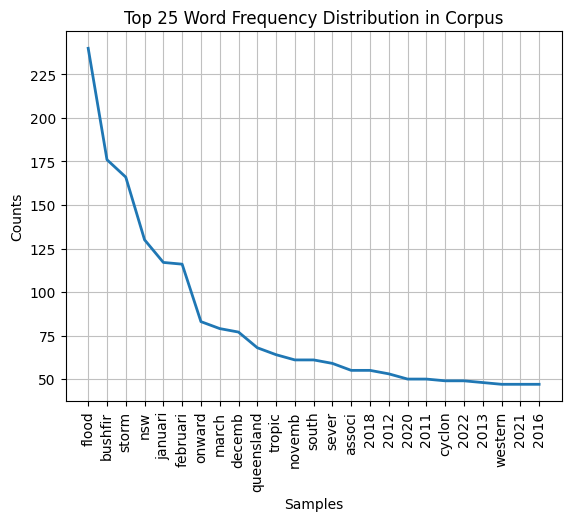

In [54]:
tokenized_corpus = event_name_df['clean_event_name']

# Flatten the list of lists containing tokenized words
flat_tokenized_corpus = [word for tokens in tokenized_corpus for word in tokens]

fdist = FreqDist(flat_tokenized_corpus)
top_n = 25
fdist.plot(top_n, cumulative=False, title=f'Top {top_n} Word Frequency Distribution in Corpus')
plt.show()

## Data Wrangling and Cleaning
We know from domain kowedlge that the complied data source is an aggragation of data from disaster assist, sorat word report and the treasury. As such drfa, agdrp, dra are expected to have null values and highlights a limitation in the underlaying data and how it was collected in the past. In addition, disaster subtype has been artifically generated through other methods and will be removed from the analisys to reudce overal noise in the machine learning model. 

We could attempt to predict/impute these values - however they do not realte to our specifc research question. As such, we will drop the following observations
- drfa
- agdrp
- dra
- disaster subtypes

In [28]:
#cols_to_drop = ["drfa", "dra", "agdrp", "disaster_subtypes"]

#df_disaster = df_disaster.drop(cols_to_drop, axis= 1)
#df_disaster.head()

,lga_code,lga_name,state,agrn,event_name,financial_year,disaster_types,start_date,end_date
0,31750,Bulloo,QLD,1067,QLD - Southwest Queensland Flooding (4 June - ...,2022-23,Flood,2023-06-04,2023-07-07
1,36150,Quilpie,QLD,1067,QLD - Southwest Queensland Flooding (4 June - ...,2022-23,Flood,2023-06-04,2023-07-07
2,17640,Upper Lachlan,NSW,1066,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,2022-23,Bushfire,2023-02-11,NaN
3,18710,Yass Valley,NSW,1066,NSW - Upper Lachlan and Yass Valley NSW Bushfi...,2022-23,Bushfire,2023-02-11,NaN
4,12160,Cootamundra-Gundagai,NSW,1065,NSW - Cootamundra-Gundagai Bushfires (25 Janua...,2022-23,Bushfire,2023-01-25,NaN
